In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})

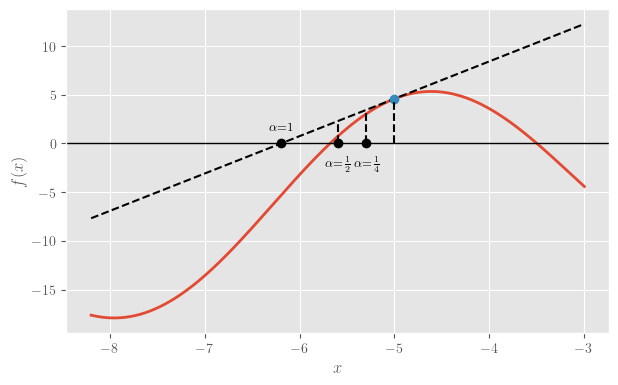

In [18]:
def f(x):
    return x + 10*np.sin(x)

def df(x):
    return 1 + 10*np.cos(x)

xi = -5.0
fxi = f(xi)
dfxi = df(xi)

# newton direction (in 1D): d = -f/df
d = -fxi/dfxi
x_newton = xi + d  # full step location (alpha = 1)

# Alphas to test
alphas = [1, 0.5, 0.25, 0.125, 0.0625]
alphas = [1, 0.25, 0.5]

# Collect results
rows = []
for a in alphas:
    x_next = xi + a*d
    fx_next = f(x_next)
    rows.append({
        "alpha": a,
        "x_{i+1}": x_next,
        "f(x_{i+1})": fx_next,
        "|f(x_{i+1})|": abs(fx_next),
        "residual decreased?": abs(fx_next) < abs(fxi)
    })

df_results = pd.DataFrame(rows)

x_min = min(xi, x_newton) - 2.0
x_max = max(xi, x_newton) + 2.0
xs = np.linspace(x_min, x_max, 600)

plt.figure(figsize=(7,4.2))
plt.plot(xs, f(xs), linewidth=2)

# x-axis
plt.axhline(0, linewidth=1, color="black")

# Tangent at xi: y = f(xi) + f'(xi)*(x - xi)
ys_tan = fxi + dfxi*(xs - xi)
plt.plot(xs, ys_tan, linestyle="--", linewidth=1.5, color="black")

# Mark xi and the vertical guide
plt.plot([xi], [fxi], marker="o")
plt.vlines(xi, 0, fxi, linestyles="dashed", color="black")

# Mark landing points for each alpha (on the x-axis) and show dashed residuals
for a in alphas:
    x_next = xi + a*d
    y_next = f(x_next)
    # point on x-axis at x_next
    plt.plot([x_next], [0], marker="o", color="black")
    # dashed line up to the tangent line
    # interpolate the tangent line at x_next
    y_tan_next = ys_tan[np.argmin(np.abs(xs - x_next))]
    plt.vlines(x_next, 0, y_tan_next, linestyles="dashed", color="black")
    # annotate
    if np.isclose(a, 0.5):
        a = "$\\frac{1}{2}$"
    elif np.isclose(a, 0.125):
        a = "$\\frac{1}{8}$"
    elif np.isclose(a, 0.25):
        a = "$\\frac{1}{4}$"
    elif np.isclose(a, 1):
        a = "1"
    if a == "1":
        plt.annotate("$\\alpha$=" + a, xy=(x_next, 0), xytext=(0, 8), textcoords="offset points",
                     ha="center", va="bottom", fontsize=9)
    else:
        plt.annotate("$\\alpha$=" + a, xy=(x_next, -4), xytext=(0, 8), textcoords="offset points",
                     ha="center", va="bottom", fontsize=9)

# Labels
# plt.title(r"Damped Newton in 1D: f(x)=x+10 sin(x),  x_i=-5\nFull step overshoots; $\alpha=1/2$ reduces the residual")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

out_path = "../../../figs/nle/damped_newton_verification.pdf"
# plt.tight_layout()
plt.savefig(out_path, transparent=False)
plt.show()

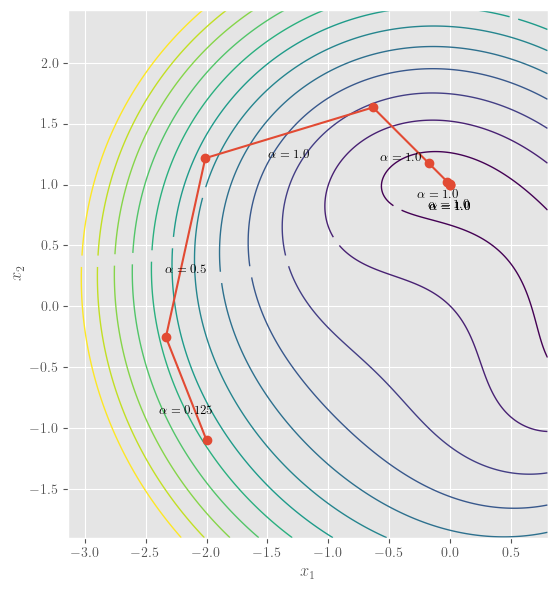

In [20]:
def f(x):
    x1, x2 = x
    return np.array([x1 + x2 - 1.0, x1**2 + x2**2 - 1.0])

def J(x):
    x1, x2 = x
    return np.array([[1.0, 1.0],
                     [2.0*x1, 2.0*x2]])

def residual(x):
    return np.linalg.norm(f(x))

# Damped Newton with backtracking
x = np.array([-2.0, -1.1], dtype=float)
max_iters = 8
tol = 1e-10
history = []
points = [x.copy()]

for k in range(max_iters):
    r = residual(x)
    if r < tol:
        break
    # Newton direction
    d = -np.linalg.solve(J(x), f(x))
    # Backtracking
    alpha = 1.0
    r0 = r
    evaluations = 0
    while True:
        x_trial = x + alpha*d
        r_trial = residual(x_trial)
        evaluations += 1
        if r_trial < r0 or alpha < 1e-10:
            break
        alpha *= 0.5
    # Accept
    x = x_trial
    points.append(x.copy())
    history.append({
        "iter": k,
        "alpha_accepted": alpha,
        "||f(x_i)||_2": r0,
        "||f(x_{i+1})||_2": r_trial,
        "evaluations": evaluations,
        "x1": x[0],
        "x2": x[1]
    })
    if r_trial < tol:
        break

df = pd.DataFrame(history)

# Contour field for the residual norm
points_arr = np.array(points)
xmin, ymin = points_arr.min(axis=0) - 0.8
xmax, ymax = points_arr.max(axis=0) + 0.8
xs = np.linspace(xmin, xmax, 400)
ys = np.linspace(ymin, ymax, 400)
XX, YY = np.meshgrid(xs, ys)
FF1 = XX + YY - 1.0
FF2 = XX**2 + YY**2 - 1.0
RES = np.sqrt(FF1**2 + FF2**2)

# Plot contours and path
fig, ax = plt.subplots(figsize=(7,6))
levels = np.linspace(np.percentile(RES, 5), np.percentile(RES, 90), 12)
CS = ax.contour(XX, YY, RES, levels=levels, linewidths=1.0)
ax.clabel(CS, inline=True, fontsize=8, fmt="")

# Plot the path and annotate accepted alphas
xs_path = [p[0] for p in points]
ys_path = [p[1] for p in points]
ax.plot(xs_path, ys_path, marker="o", linestyle="-")
for row, p_from, p_to in zip(history, points[:-1], points[1:]):
    xm = (p_from[0] + p_to[0]) / 2
    ym = (p_from[1] + p_to[1]) / 2
    ax.annotate(rf"$\alpha={row['alpha_accepted']}$", xy=(xm, ym), xytext=(0, -12),
                textcoords="offset points", ha="center", va="top", fontsize=9)

# ax.set_title("Damped Newton with backtracking (actual run)")
ax.set_xlabel(r"$x_1$"); ax.set_ylabel(r"$x_2$")
ax.set_aspect("equal", adjustable="box")


plt.tight_layout()
out_path = "../../../figs/nle/damped_newton_2d_backtracking.pdf"
plt.savefig(out_path, transparent=False)
plt.show()